In [ ]:
# Split the data
import numpy as np
import cv2
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.multiclass import  OneVsOneClassifier,OneVsRestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
# Load processed feature matrix and labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from skimage.filters import sobel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import mean_squared_error


In [ ]:


# TODO: Add any util functions you may have from the previous script

# Load the handwritten digits dataset
digits = load_digits()

# TODO: Load the raw data

X,y = digits.data,digits.target

In [ ]:


#####
#In machine learning, we must train the model on one subset of data and test it on another.
#This prevents the model from memorizing the data and instead helps it generalize to unseen examples.
#The dataset is typically divided into:
#Training set → Used for model learning.
#Testing set → Used for evaluating model accuracy.
# The training set is also split as a training set and validation set for hyper-parameter tunning. This is done later
#
# Split dataset into training & testing sets


##########################################
## Train/test split and distributions
##########################################


# 1- Split dataset into training & testing sets
# TODO: FILL OUT THE CORRECT SPLITTING HERE
# Normalisation des données
F=MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(F, y, test_size=0.2, random_state=42)
### If you want, you could save the data, this would be a good way to test your final script in the same evaluation mode as what we will be doing
# np.save("X_train.npy", X_train)
# np.save("test_data.npy", X_test)
# np.save("y_train.npy", y_train)
# np.save("test_label.npy", y_test)
####

# TODO: Print dataset split summary...
print(f"X Training set : {X_train.shape[0]} samples.")
print(f"y Training set : {y_train.shape[0]} samples.")
print(f"X Testing set : {X_test.shape[0]} samples.")
print(f"y Testing set : {y_test.shape[0]} samples.")

X Training set : 1437 samples.
y Training set : 1437 samples.
X Testing set : 360 samples.
y Testing set : 360 samples.


In [ ]:
X_test.shape

(360, 64)

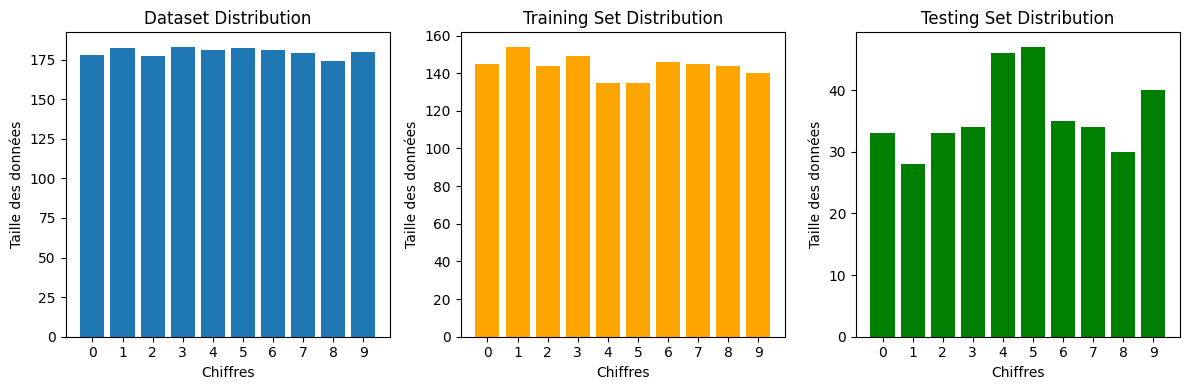

In [ ]:
# TODO: ... and plot graphs of the three distributions in a readable and useful manner (bar graph, either side by side, or with some transparancy)

plt.figure(figsize=(12, 4))


plt.subplot(1, 3, 1) # 1 row, 3 columns, first plot
labels, counts=np.unique(y, return_counts=True)
plt.bar(labels, counts)
plt.title('Dataset Distribution')
plt.xlabel("Chiffres")
plt.ylabel("Taille des données")
plt.xticks(labels)


plt.subplot(1, 3, 2)
unique_train, counts_train = np.unique(y_train, return_counts=True)
plt.bar(unique_train, counts_train, color='orange')
plt.title('Training Set Distribution')
plt.xlabel("Chiffres")
plt.ylabel("Taille des données")
plt.xticks(unique_train)


plt.subplot(1, 3, 3)
unique_test, counts_test = np.unique(y_test, return_counts=True)
plt.bar(unique_test, counts_test, color='green')
plt.title('Testing Set Distribution')
plt.xlabel("Chiffres")
plt.ylabel("Taille des données")
plt.xticks(unique_test)

plt.tight_layout()
plt.show()


In [ ]:
# TODO: (once the learning has started, and to be documented in your report) - Impact: Changing test_size affects model training & evaluation.

def extract_zone_features(images):
  n_data,n_target=images.shape
  zones=[]
  for img in images :
    img8=img.reshape(8,8)
    zone1_mean=np.mean(img8[:3,:])
    zone2_mean=np.mean(img8[3:5,:])
    zone3_mean=np.mean(img8[5:,:])
    zones.append([zone1_mean,zone2_mean,zone3_mean])
  return np.array(zones)

def gradient_features(image):
    # Appliquer Sobel
    sobel_x=cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y=cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude=np.sqrt(sobel_x**2 + sobel_y**2)

    return magnitude


pca=PCA(n_components=30)




In [ ]:
# concaténation en utilisant hstack
pca.fit(X_train)
features1=pca.transform(X_train)  # PCA features
features2=extract_zone_features(X_train)
features3=gradient_features(X_train)

def matrice_concatenate(features1, features2, features3):
    return np.hstack((features1, features2, features3))


In [ ]:

##########################################
## Prepare preprocessing pipeline
##########################################

# We are trying to combine some global features fitted from the training set
# together with some hand-computed features.
#
# The PCA shall not be fitted using the test set.
# The handmade features are computed independently from the PCA
# We therefore need to concatenate the PCA computed features with the zonal and
# edge features.
# This is done with the FeatureUnion class of sklearn and then combining everything in
# a Pipeline.
#
# All elements included in the FeatureUnion and Pipeline shall have at the very least a
# .fit and .transform method.
#
# Check this documentation to understand how to work with these things
# https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html#sphx-glr-auto-examples-compose-plot-feature-union-py



# Example of wrapper for adding a new feature to the feature matrix
from sklearn.base import BaseEstimator, TransformerMixin


class EdgeInfoPreprocessing(BaseEstimator, TransformerMixin):
    '''A class used to compute an average Sobel estimator on the image
       This class can be used in conjunction of other feature engineering
       using Pipelines or FeatureUnion
    '''
    def __init__(self):
      pass

    def fit(self, X, y=None):
        return self # No fitting needed for this processing

    def transform(self, X):
        sobel_feature = np.array([np.mean(sobel(img.reshape((8,8)))) for img in X]).reshape(-1, 1)
        return sobel_feature



class ZonalInfoPreprocessing(BaseEstimator, TransformerMixin):
    '''A class used to compute zone information on the image
       This class can be used in conjunction of other feature engineering
       using Pipelines or FeatureUnion
    '''

    def fit(self, X, y=None):
        return self # No fitting needed for this processing

    def transform(self, X):
        # Example: Simple zonal feature by taking the average of the top-left quadrant
        # You can define more complex zonal features based on your needs
        zones=[]
        for img in X:
          img8=img.reshape(8,8)
          zone1_mean=np.mean(img8[:3,:])
          zone2_mean=np.mean(img8[3:5,:])
          zone3_mean=np.mean(img8[5:,:])
          zones.append([zone1_mean,zone2_mean,zone3_mean])
        return np.array(zones)


In [ ]:
# TODO: Create a single sklearn object handling the computation of all features in parallel
features=FeatureUnion([('pca', PCA(n_components=30)),('edge', EdgeInfoPreprocessing()),('zones', ZonalInfoPreprocessing())])



F=features.fit(X_train,y_train).transform(X_train)
# Let's make sure we have the number of dimensions that we expect!
print("Nb features computed: ", F.shape[1])

Nb features computed:  34


In [ ]:

# Now combine everything in a Pipeline
# The clf variable is the one which plays the role of the learning algorithms
# The Pipeline simply allows to include the data preparation step into it, to
# avoid forgetting a scaling, or a feature, or ...
#
# TODO: Write your own pipeline, with a linear SVC classifier as the prediction
#'prescale',MinMaxScaler()
clf = Pipeline([("scaler", MinMaxScaler()),("features", features),("classifier", SVC(kernel='linear'))])


# Entraînement
clf.fit(X_train, y_train)
predict_test = [1]*len(X_test)
predict_train = [1]*len(X_train)

print("Accuracy of the SVC on the test set: ", sum(y_test==predict_test)/len(y_test))
print("Accuracy of the SVC on the train set: ", sum(y_train==predict_train)/len(y_train))




Accuracy of the SVC on the test set:  0.07777777777777778
Accuracy of the SVC on the train set:  0.10716771050800278


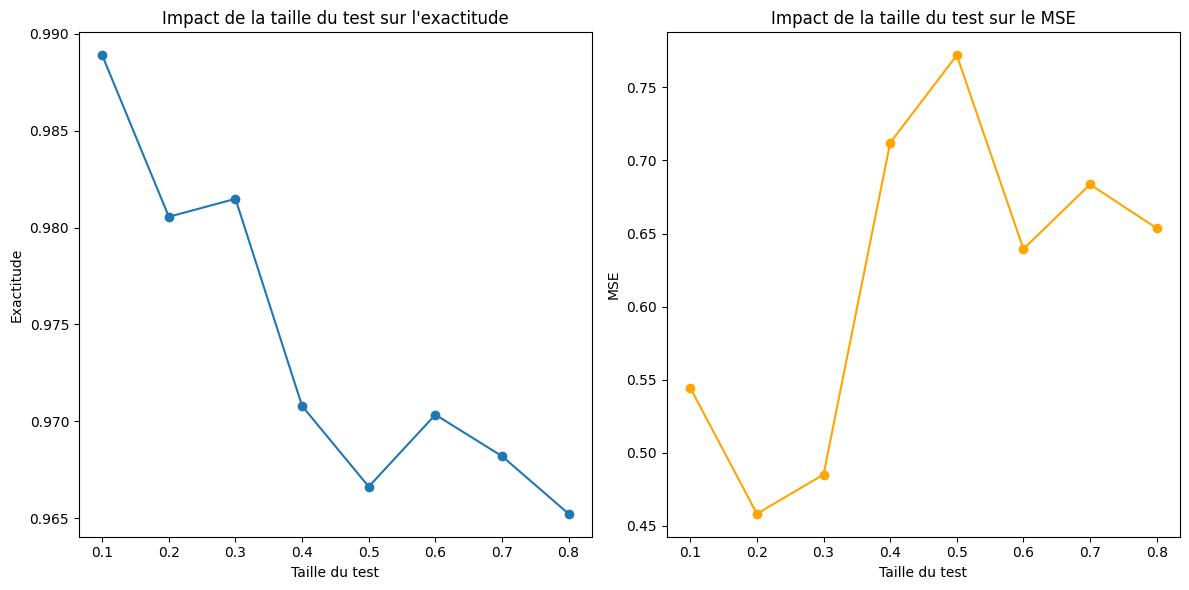

In [ ]:


def evaluate_model(test_size):

    digits = load_digits()
    X, y = digits.data, digits.target


    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    clf.fit(X_train_split, y_train_split)

    y_pred = clf.predict(X_test_split)
    accuracy = accuracy_score(y_test_split, y_pred)
    mse = mean_squared_error(y_test_split, y_pred)
    return accuracy, mse

def plot_test_size_effect():
    digits = load_digits()
    global X, y
    X, y = digits.data, digits.target

    test_sizes = np.arange(0.1, 0.9, 0.1)
    accuracies = []
    mses = []

    for size in test_sizes:
        accuracy, mse = evaluate_model(size)
        accuracies.append(accuracy)
        mses.append(mse)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(test_sizes, accuracies, marker='o')
    plt.title('Impact de la taille du test sur l\'exactitude')
    plt.xlabel('Taille du test')
    plt.ylabel('Exactitude')

    plt.subplot(1, 2, 2)
    plt.plot(test_sizes, mses, marker='o', color='orange')
    plt.title('Impact de la taille du test sur le MSE')
    plt.xlabel('Taille du test')
    plt.ylabel('MSE')

    plt.tight_layout()
    plt.show()

digits = load_digits()
X, y = digits.data, digits.target

plot_test_size_effect()

Accuracy of the SVC on the test set:  0.9777777777777777
Accuracy of the SVC on the train set:  1.0

Confusion Matrix (Test Set):
 [[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  1  0 44  1  0  0  1]
 [ 0  0  0  0  1  0 34  0  0  0]
 [ 0  0  0  0  0  1  0 33  0  0]
 [ 0  1  0  0  0  0  0  0 29  0]
 [ 0  0  0  0  0  0  0  0  1 39]]


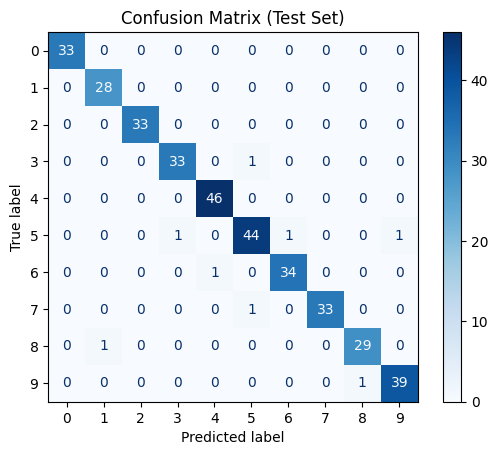


Understanding the Confusion Matrix:
The confusion matrix shows the number of correct and incorrect predictions per class.
The diagonal elements represent the number of samples correctly classified for each digit.
Off-diagonal elements represent misclassifications. For example, cm[i, j] is the number of samples of true class i that were predicted as class j.
A good classifier will have high values on the diagonal and low values elsewhere.

Question: How does changing test_size influence accuracy?
Try different values like 0.1, 0.3, etc., and compare results.

Impact of varying test_size:
  - With test_size=0.1: Accuracy = 0.9778
  - With test_size=0.3: Accuracy = 0.9722
  - With test_size=0.5: Accuracy = 0.9700


In [ ]:

# 1. Entraînement du modèle via la pipeline
clf=Pipeline([('features', features), ('scaler', StandardScaler()), ('classifier', SVC(kernel='linear'))])
clf.fit(X_train, y_train)

# 2. Prédictions sur le train et le test set
predict_train=clf.predict(X_train)
predict_test=clf.predict(X_test)

# 3. Calcul et affichage des accuracies
print("Accuracy of the SVC on the test set: ", (y_test==predict_test).mean())
print("Accuracy of the SVC on the train set: ", (y_train==predict_train).mean())



# 4. Matrice de confusion
cm=confusion_matrix(y_test, predict_test)

# 1. Affichage de la matrice brute
print("\nConfusion Matrix (Test Set):\n", cm)

# 2. Affichage graphique
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')
plt.show()

# 3. Analyse
print("\nUnderstanding the Confusion Matrix:")
print("The confusion matrix shows the number of correct and incorrect predictions per class.")
print("The diagonal elements represent the number of samples correctly classified for each digit.")
print("Off-diagonal elements represent misclassifications. For example, cm[i, j] is the number of samples of true class i that were predicted as class j.")
print("A good classifier will have high values on the diagonal and low values elsewhere.")

# 5. Influence de test_size sur l'accuracy
print("\nQuestion: How does changing test_size influence accuracy?")
print("Try different values like 0.1, 0.3, etc., and compare results.\n")

test_sizes=[0.1, 0.3, 0.5]
print("Impact of varying test_size:")
for ts in test_sizes:
    X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X, y, test_size=ts, random_state=42)
    clf_ts = Pipeline([('features', features), ('scaler', StandardScaler()), ('classifier', SVC(kernel='linear'))])
    clf_ts.fit(X_train_ts, y_train_ts)
    accuracy_ts = clf_ts.score(X_test_ts, y_test_ts)
    print(f"  - With test_size={ts:.1f}: Accuracy = {accuracy_ts:.4f}")


In [ ]:
# @title

# Pipeline complet
clf_rbf = Pipeline([
    ('features', features),  # le sous-pipeline avec le PCA
    ('scaler', StandardScaler()),  # scaler explicite pour pouvoir le modifier
    ('classifier', SVC())          # pas besoin de préciser le kernel ici, il sera dans le param_grid
])

clf_rbf.set_params(classifier__kernel='rbf')
# Dictionnaire des paramètres à tester
param_grid = dict(
    'features__pca__n_components': [20, 25, 30],  # Pourcentage de variance à garder
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [0.01, 0.05, 0.1, 0.25, 0.5],
)

# GridSearch sur le pipeline (PAS sur DummyClassifier)
start_time_ovr = time.time()
grid_search = GridSearchCV(clf_rbf, param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)
end_time_ovr = time.time()

# Résultats du cross-validation
print("\nK-Fold Cross-Validation Results:")
print(f"- Best Cross-validation score: {grid_search.best_score_:.4f}")
print(f"- Best parameters found: {grid_search.best_params_}")

# Mettre à jour le pipeline avec les meilleurs paramètres
best_clf = grid_search.best_estimator_

# Évaluer sur le test set
best_accuracy_test = best_clf.score(X_test, y_test)
print(f"- Test set accuracy with optimized parameters: {best_accuracy_test:.4f}")

print("\nQuestion: What happens if we change K from 5 to 10?")
print("Test different K values and compare the accuracy variation.\n")

# Impact du nombre de folds
print("Impact of varying K in K-Fold Cross-Validation:")
kf_values = [5, 10]
for k in kf_values:
    grid_search_k = GridSearchCV(clf_rbf, param_grid, cv=k, verbose=0)
    grid_search_k.fit(X_train, y_train)
    print(f"  - With K={k}: Best CV Score = {grid_search_k.best_score_:.4f}, Best Parameters = {grid_search_k.best_params_}")


print(f"- Training time: {end_time_ovr - start_time_ovr:.4f} seconds")

In [ ]:

##########################################
## OvO and OvR
##########################################
# TODO: Using the best found classifier, analyse the impact of one vs one versus one vs all strategies
# Analyse in terms of time performance and accuracy


# OvO Classifier
ovo_clf = OneVsOneClassifier(best_clf.named_steps['classifier']) # Use the best found classifier base estimator
ovo_pipeline = Pipeline([
    ('features', features),
    ('scaler', StandardScaler()),
    ('classifier', ovo_clf)
])

start_time_ovo = time.time()
ovo_pipeline.fit(X_train, y_train)
end_time_ovo = time.time()
ovo_test_score = ovo_pipeline.score(X_test, y_test)

# Print OvO results
print("\n One-vs-One (OvO) Classification:")
print(f"- Test score: {ovo_test_score:.4f}")
# The number of classifiers trained in OvO is n_classes * (n_classes - 1) / 2
n_classes = len(np.unique(y))
n_ovo_classifiers = n_classes * (n_classes - 1) // 2
print(f"- Number of classifiers trained: {n_ovo_classifiers}")
print(f"- Training time: {end_time_ovo - start_time_ovo:.4f} seconds")
print("- Impact: Suitable for small datasets but increases complexity as the number of classes grows.")

print("\n Question: How does OvO compare to OvR in execution time?")
print("Try timing both methods and analyzing efficiency.\n")






NameError: name 'best_clf' is not defined

In [ ]:
###################
# TODO:  One-vs-Rest (OvR) Classification
ovr_clf = OneVsRestClassifier(best_clf.named_steps['classifier']) # Use the best found classifier base estimator
ovr_pipeline = Pipeline([
    ('features', features),
    ('scaler', StandardScaler()),
    ('classifier', ovr_clf)
])

start_time_ovr = time.time()
ovr_pipeline.fit(X_train, y_train)
end_time_ovr = time.time()
ovr_test_score = ovr_pipeline.score(X_test, y_test)

# Print OvR results
print("\n One-vs-Rest (OvR) Classification:")
print(f"- Test score: {ovr_test_score:.4f}")
# The number of classifiers trained in OvR is equal to the number of classes
n_ovr_classifiers = n_classes
print(f"- Number of classifiers trained: {n_ovr_classifiers}")
print(f"- Training time: {end_time_ovr - start_time_ovr:.4f} seconds")
print("- Impact: Better for large datasets but less optimal for highly imbalanced data.")

print("\n Question: When would OvR be better than OvO?")
print("Analyze different datasets and choose the best approach!\n")
print("Answer: OvR trains n_classes classifiers, while OvO trains n_classes * (n_classes - 1) / 2 classifiers. For a large number of classes, OvR is generally faster to train than OvO because it trains fewer classifiers. However, OvO can sometimes achieve better accuracy, especially if the classes are not linearly separable, as it trains binary classifiers for each pair of classes.")
print("Consider OvR for large datasets with many classes where training time is a concern. Consider OvO when the number of classes is small or when higher accuracy is prioritized, even if it means longer training times.")

########



NameError: name 'best_clf' is not defined